# Convergent beam STEM diffraction with bullseye probe

In convergent beam electron diffraction (CBED), each diffraction spot is convoluted with the aperture in the diffraction pattern. A bullseye aperture instead of a round aperture yields a diffraction pattern that is particularly suitable to find peak positions through correlation with a matching template pattern. The complex shape and increased number of edges in the bullseye pattern allows to determine the position precisely and reliably even in situations with low beam intensity and many overlapping diffraction disks.

This example shows how to identify individual crystallites in diffraction data from a polycrystalline sample that was recorded with a bullseye probe using [LiberTEM](https://libertem.github.io/LiberTEM/). First, the positions of diffraction spots are determined across the dataset in a global averaged frame. Then, a feature vector is calculated for each frame by determining the the presence of absence of each spot. The feature fector is normalized to balance the relative weights of the spots. Finally, the feature vector is clustered with agglomerative clustering and a connectivity matrix that only connects next neighbors. That way, similar neighboring frames are joined in a cluster that corresponds to a crystallite in the sample.

Data set:

Ophus, Colin, & Savitzky, Benjamin. (2019). Simulated calibration dataset for 4D scanning transmission electron microscopy [Data set]. Zenodo. http://doi.org/10.5281/zenodo.3592520

Paper on patterned STEM probes:

Steven E Zeltmann, Alexander Müller, Karen C Bustillo, Benjamin Savitzky, Lauren Hughes, Andrew M Minor, Colin Ophus. (2020).: Patterned probes for high precision 4D-STEM bragg measurements. Ultramicroscopy.
https://doi.org/10.1016/j.ultramic.2019.112890. [arXiv:1907.05504](https://arxiv.org/abs/1907.05504)

## Notes
* If you'd like to experiment with this notebook, you should first run all cells to populate all variables.
* LiberTEM performs much better on dedicated systems than on Binder

## Threading Setup
Set thread count of numerics libraries to 1 since LiberTEM relies on multiprocessing with one process per core
for parallelization. Using more than one thread per process leads to poor performance due to oversubscription
of the CPU

In [1]:
import os

os.environ["OMP_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"

## Download file

In [2]:
from urllib.parse import urlparse

import requests
import tqdm

In [3]:
url = 'https://zenodo.org/record/3592520/files/calibrationData_bullseyeProbe.h5?download=1'
u = urlparse(url)

filename = os.path.basename(u.path)

In [4]:
def get_file(url, filename):
    r = requests.get(url, stream=True)
    total_size = int(r.headers.get('content-length', 0))
    block_size = 2**20 # 1 MiB
    progress = tqdm.tqdm(total=total_size, unit='iB', unit_scale=True)
    with open(filename, 'wb') as f:
        for chunk in r.iter_content(chunk_size=block_size):
            progress.update(len(chunk))
            f.write(chunk)
    progress.close()

In [5]:
if not os.path.exists(filename):
    get_file(url, filename)        

## Data processing with LiberTEM

In [6]:
# Activate interactive matplotlib plots
%matplotlib nbagg

In [7]:
import functools

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import cm
import sklearn.feature_extraction
import sklearn.cluster

from libertem_blobfinder.common import correlation, patterns

from libertem import api
import libertem.masks as masks
import libertem.udf.logsum as logsum
import libertem.udf.stddev as stddev
from libertem.udf.masks import ApplyMasksUDF
from libertem.udf import UDF

# InlineJobExecutor works better on Binder for the time being
from libertem.executor.inline import InlineJobExecutor

### Start a local cluster

In [8]:
# InlineJobExecutor works better on Binder for the time being
ctx = api.Context(executor=InlineJobExecutor())
# ctx = api.Context()

### Create a handle for the data file
This doesn't load the data, it just determines some metadata. See https://libertem.github.io/LiberTEM/formats.html#loading-through-the-api for more info on loading data.

In [9]:
ds = ctx.load(
    'HDF5',
    path=filename,
    ds_path='4DSTEM_experiment/data/datacubes/polyAu_4DSTEM/data',
    tileshape=(1, 16, 16, 250)
)

### Sum of log-scaled frames
This method log-scales each frame individually and then sums them up. This method highlights peaks that are present in many frames. In this case, it strongly shows the zero order peak with the bullseye pattern.

In [10]:
ls_udf = logsum.LogsumUDF()
%time ls = ctx.run_udf(dataset=ds, udf=ls_udf)
ls_data = ls['logsum'].data

CPU times: user 10.7 s, sys: 245 ms, total: 10.9 s
Wall time: 11 s


<IPython.core.display.Javascript object>


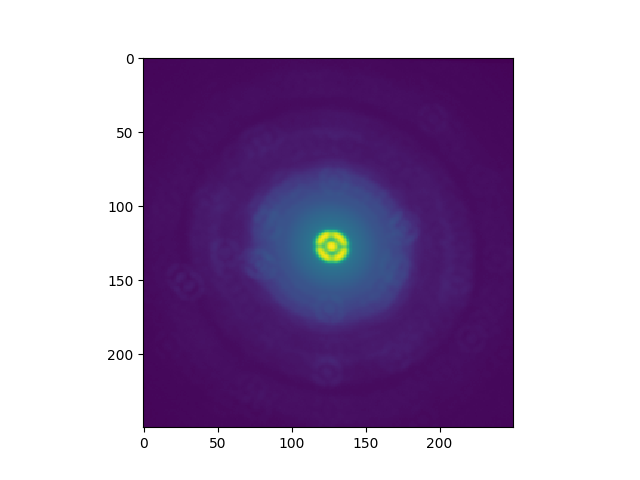

In [11]:
fig, axes = plt.subplots()
plt.imshow(ls_data, norm=LogNorm())

### Show an individual frame

In [12]:
pick = ctx.create_pick_analysis(dataset=ds, x=43, y=29)
%time pick_res = ctx.run(pick)

CPU times: user 5.71 ms, sys: 991 µs, total: 6.7 ms
Wall time: 5.95 ms


<IPython.core.display.Javascript object>


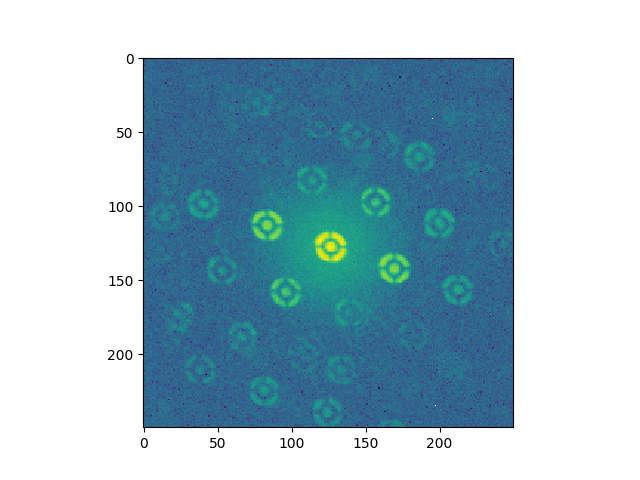

In [13]:
fig, axes = plt.subplots()
plt.imshow(pick_res.intensity.raw_data, norm=LogNorm())

### Build the bullseye correlation template
This builds the template by combining primitive shapes, matching the dimensions in the diffraction data as closely as possible.

In [14]:
# Center
cy, cx = 15, 15
# Size
dy, dx = 31, 31
# Radius of central spot
rii = 2.8
# Inner radius of bright ring
ri = 8
# Outer radius of bright ring
ro = 11.5
# Outer radius of exclusion zone
roo = 16
# x, y coordinates for filtering
y, x = np.ogrid[0:dy, 0:dx]

# `cross` is a boolean array that contains all pixels which are blanked out by the supports of the dark ring
# It is built up step by step.
# Between one pixel left and right of the center OR between one pixel above and below the center
cross = (y >= cy-1) * (y <= cy+1) + (x >= cx-1) * (x <= cx+1)
# Only include pixels have a distance from the center of a tleast the inner radius of the bright ring
cross *= ((x-cx)**2 + (y-cy)**2 >= ri**2)

# Neutral region beyond the exclusion zone
zero = (x-cx)**2 + (y-cy)**2 > roo**2

# Default parameters for mask functions in LiberTEM
default_params = dict(centerX=cx, centerY=cy, imageSizeX=dx, imageSizeY=dy, antialiased=True)

# Inner bright spot set to 1
template = masks.circular(**default_params, radius=rii)
# Add bright ring set to 1
template += masks.ring(**default_params, radius=ro, radius_inner=ri)

# Set all zero values to nominal negative value for subsequent balancing
template[template==0] = -0.01
# Additionally, set cross region to nominal negative value
template[cross] = -0.01

# Reset neutral region to precisely zero
template[zero] = 0

# Balance the values of positive and negative mask parts in such a way that the sum of the template is zero
# That way, correlating the template with a constant background or linear gradient yields precisely zero
# and correlating with random values yields a result close to zero.
# That is the key to find peaks with high selectivity and sensitivity.
template = masks.balance(template)

<IPython.core.display.Javascript object>


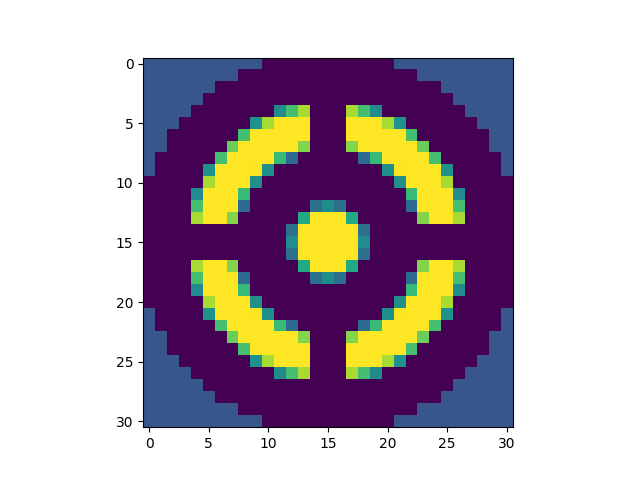

In [15]:
fig, axes = plt.subplots()
plt.imshow(template)

In [16]:
corr = patterns.UserTemplate(template)

### Find the average position of the zero order peak
Note that the position shifts across the scan area due to a slight descan error, which is very common for any STEM diffraction data! The shape in the log-summed frame is slightly smeared out for that reason.

#### Calculate and show the correlation pattern for clarity

It shows a sharp, well-defined peak

In [17]:
corrmap = correlation.get_correlation(ls_data, corr)

<IPython.core.display.Javascript object>


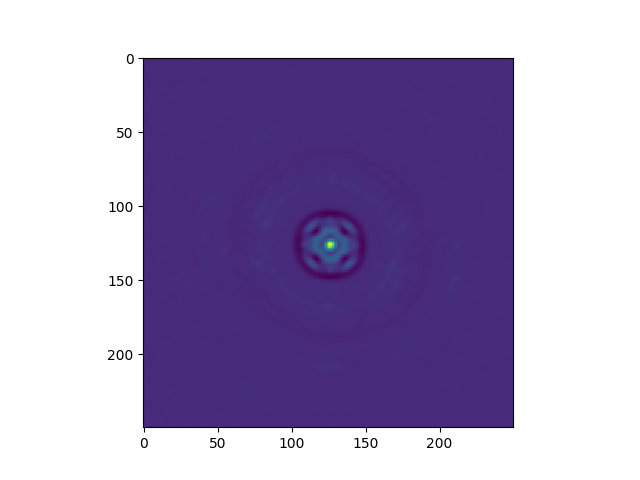

In [18]:
fig, axes = plt.subplots()
plt.imshow(corrmap)

In [19]:
zero = correlation.get_peaks(ls_data, match_pattern=corr, num_peaks=1)[0]

<IPython.core.display.Javascript object>


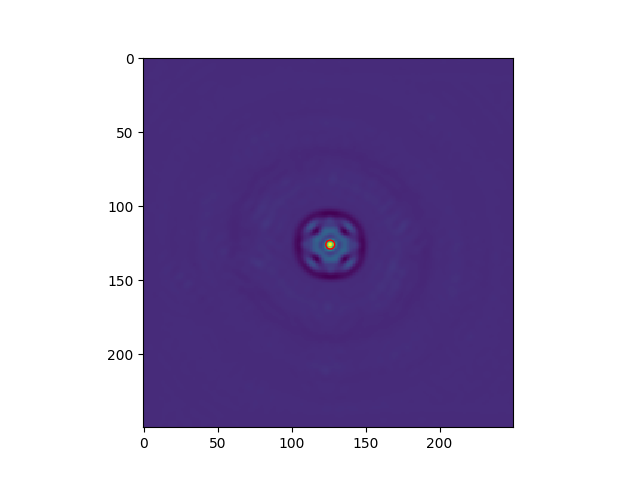

In [20]:
fig, axes = plt.subplots()
plt.imshow(corrmap)

In [21]:
# Highlight the zero position in above plot
axes.add_artist(plt.Circle(np.flip(zero), 3, color="r", fill=False))

### Calculate standard deviation map
This calculates the standard deviation of each pixel along the navigation dimension, i.e. how much a pixel varies from frame to frame. This highlights diffraction spots that vary between scan positions.

In [22]:
%time stddev_result = stddev.run_stddev(ctx, ds)

CPU times: user 6.67 s, sys: 249 ms, total: 6.92 s
Wall time: 7.04 s


<IPython.core.display.Javascript object>


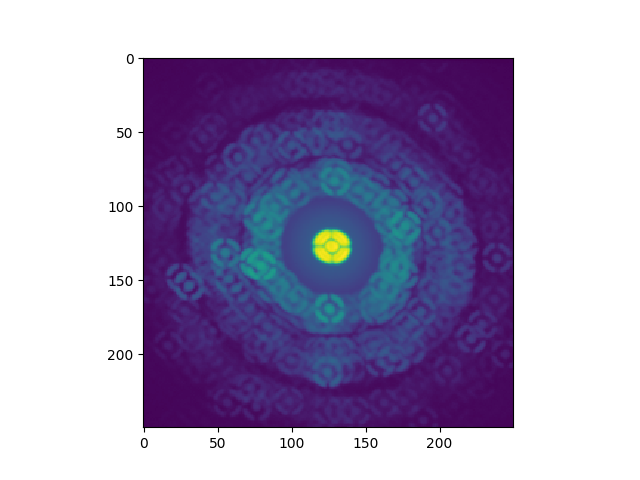

In [23]:
fig, axes = plt.subplots()
axes.imshow(stddev_result['std'], norm=LogNorm())

In [24]:
logscale_std = np.log(stddev_result['std'] - np.min(stddev_result['std']) + 1)
corrmap_std = correlation.get_correlation(logscale_std, corr)

In [25]:
# The number of peaks can be chosen fairly high since calculating the feature vector
# and clustering are fast and additional positions between peaks don't cause harm
std_found_peaks = correlation.get_peaks(sum_result=logscale_std, match_pattern=corr, num_peaks=500)

<IPython.core.display.Javascript object>


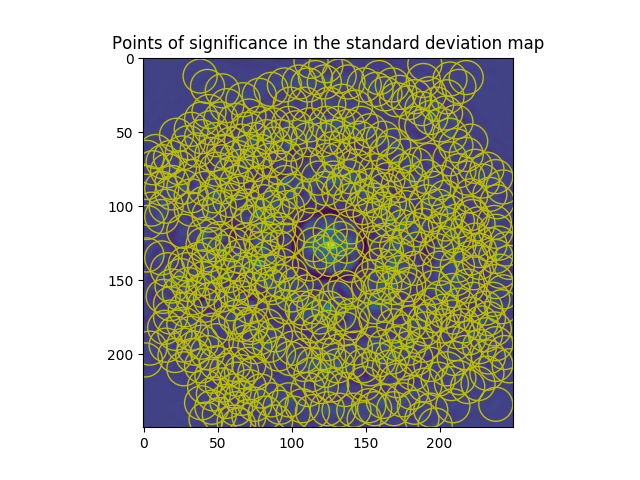

In [26]:
fig, axes = plt.subplots()
plt.imshow(corrmap_std)

In [27]:
# Highlight the found peaks in above plot
plt.title("Points of significance in the standard deviation map")
for p in np.flip(std_found_peaks, axis=1):
    axes.add_artist(plt.Circle(p, ro, color="y", fill=False))

### Generate the feature vector for each frame

In [28]:
fy, fx = ds.shape.sig

# This is wrapping the feature_vector function with functools.partial to pass the parameters.
# This function generates a sparse mask stack where a copy of the correlation template is
# placed at each potential peak position
# This generates a large stack of virtual dark field images and allows to
# calculate differences between frames more efficiently than using all pixels in a frame
stack = functools.partial(
    patterns.feature_vector,
    imageSizeX=fx,
    imageSizeY=fy,
    peaks=std_found_peaks,
    match_pattern=corr,
)

# This user-defined function (UDF) applies the mask stack to the dataset
feature_vec_udf = ApplyMasksUDF(
    mask_factories=stack,
    use_sparse=True,
    mask_count=len(std_found_peaks),
    mask_dtype=np.float32
)
%time feature_res = ctx.run_udf(dataset=ds, udf=feature_vec_udf)

CPU times: user 13.4 s, sys: 1.6 s, total: 15 s
Wall time: 15 s


In [29]:
# Normalize the feature vector dimension so that the distance is not dominated by strong peaks only
feature_vecs = feature_res['intensity'] / np.abs(feature_res['intensity']).mean(axis=(0,1))

<IPython.core.display.Javascript object>


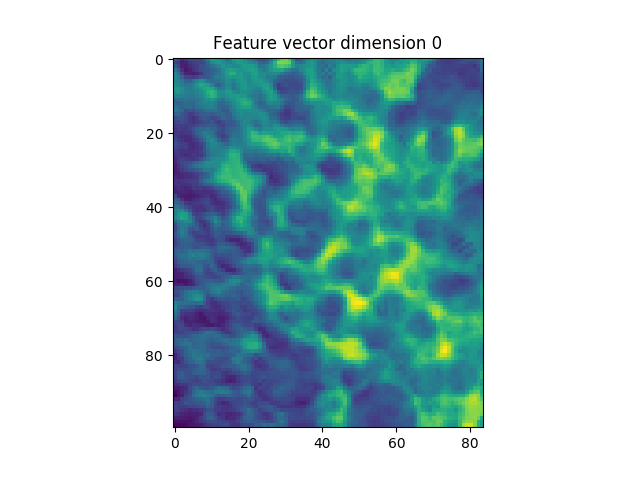

<IPython.core.display.Javascript object>


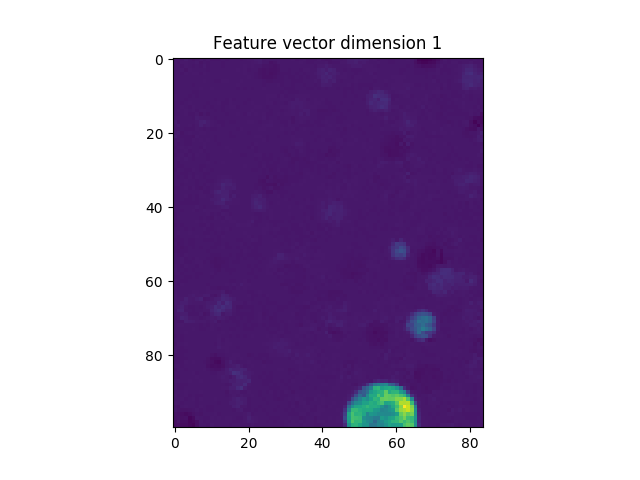

<IPython.core.display.Javascript object>


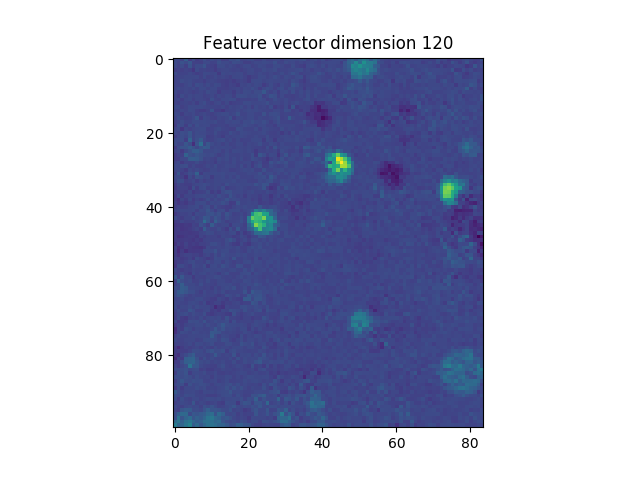

<IPython.core.display.Javascript object>


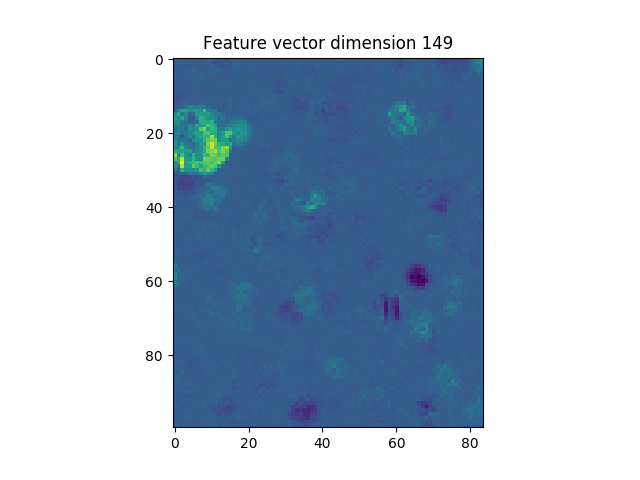

In [30]:
# Show some of the feature vectors. They are virtual darkfield images.
y, x = ds.shape.nav
for i in (0, 1, 120, 149):
    fig, axes = plt.subplots()
    axes.imshow(feature_vecs[..., i])
    plt.title("Feature vector dimension %s" % i)

### Clustering

In [31]:
# This connectivity matrix connects neighboring pixels
# That way, only pixels that are linked to each other can be part of the same cluster
connectivity = sklearn.feature_extraction.image.grid_to_graph(
    # Transposed!
    n_x=y,
    n_y=x
)

# You can vary the distance threshold to get different clustering results
clusterer = sklearn.cluster.AgglomerativeClustering(
    affinity='euclidean',
    n_clusters=None,
    distance_threshold=200,
    linkage='ward',
    connectivity=connectivity,
)

# The navigation dimension is flattened for clustering since
# clustering expects a 2D matrix with shape (n_samples, n_features)
clusterer.fit(feature_vecs.reshape((y*x, -1)))

AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=<8400x8400 sparse matrix of type '<class 'numpy.int64'>'
	with 41632 stored elements in COOrdinate format>,
                        distance_threshold=200, linkage='ward', memory=None,
                        n_clusters=None, pooling_func='deprecated')

In [32]:
# Fold the navigation dimension back into shape
labels = clusterer.labels_.reshape((y, x))

<IPython.core.display.Javascript object>


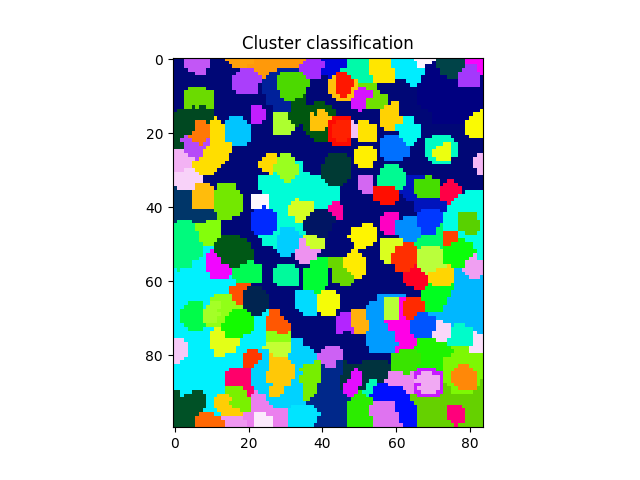

Text(0.5, 1.0, 'Cluster classification')

In [33]:
fig, axes = plt.subplots()
axes.imshow(labels, cmap=cm.gist_ncar)
plt.title("Cluster classification")